In [1]:
import torch
from PIL import Image
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
import clip

In [19]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    # ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
image = np.array(Image.open('image2.png'))
image = image[:, :, :3]

In [5]:
sam = sam_model_registry['default'](checkpoint='sam_vit_h_4b8939.pth')
sam.to(device='cuda')

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [6]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=6,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10,
)

In [7]:
masks = mask_generator.generate(image)

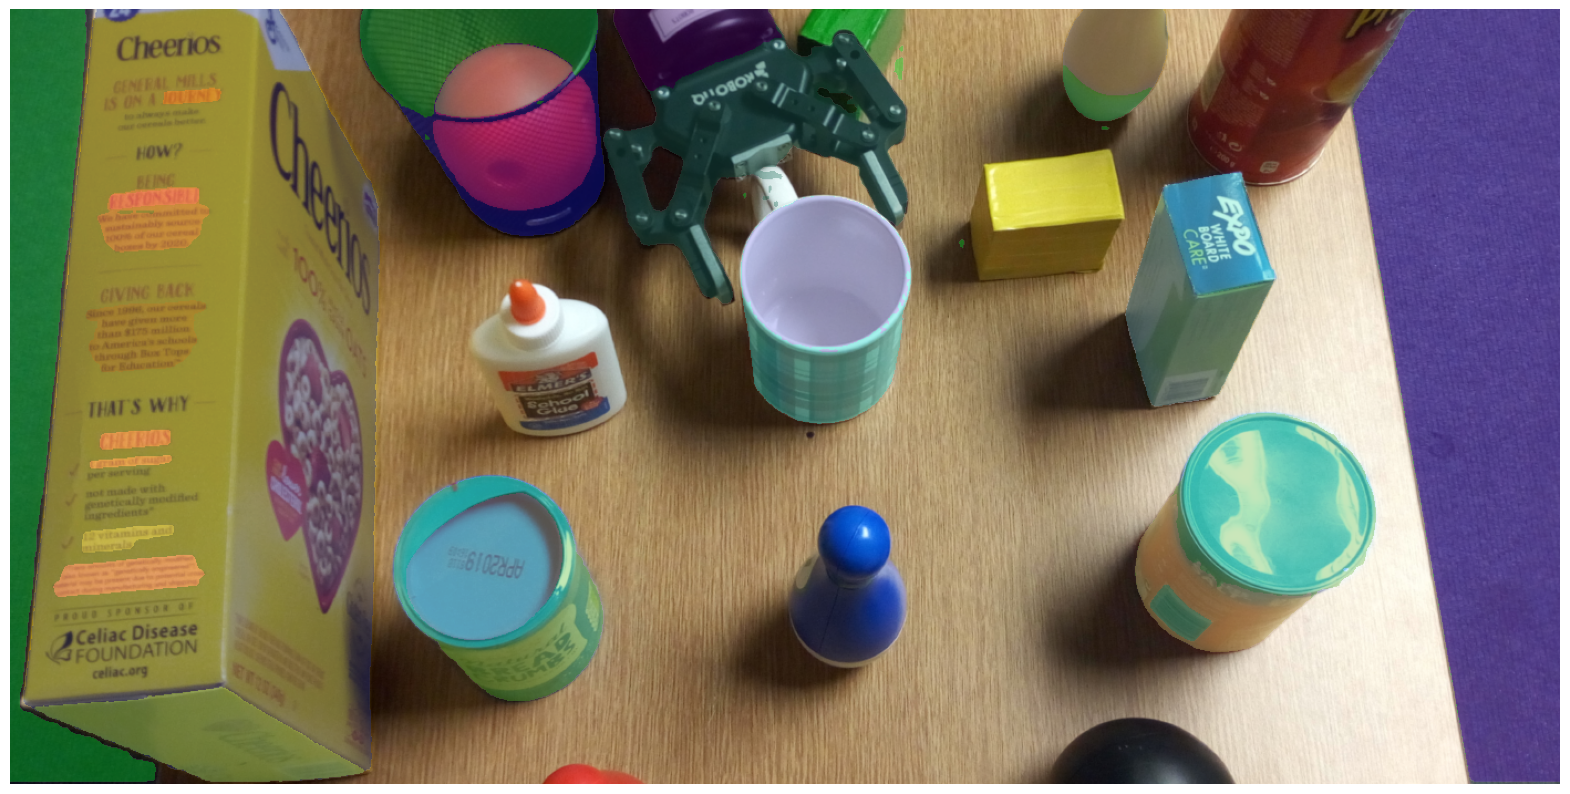

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Try Clip Embeddings

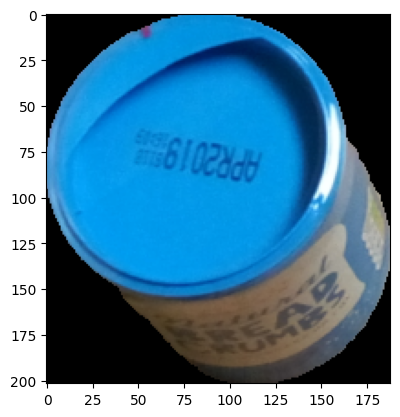

In [28]:
object_id = 6

sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
segmentation_mask = sorted_masks[object_id]['segmentation'][..., None]
bbox = sorted_masks[object_id]['bbox']
segmented_image = image * segmentation_mask
cropped_image = segmented_image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]

if cropped_image.shape[0] > 0 and cropped_image.shape[1] > 0:
    plt.imshow(cropped_image)
    plt.show()

In [12]:
text_prompts = [
    'bowl of cereals',
    'cereals',
    'carton',
    'pack of cereals',
    'box',
    'christmas present',
    'cheetos'
]

In [13]:
model, preprocess = clip.load("ViT-B/32", device='cuda')

In [14]:
clip_image = preprocess(Image.fromarray(cropped_image)).unsqueeze(0).to('cuda')
clip_text = clip.tokenize(text_prompts).to('cuda')

with torch.no_grad():
    logits_per_image, logits_per_text = model(clip_image, clip_text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

for i in range(clip_image.shape[0]):
    for j in range(len(text_prompts)):
        text_prompt = text_prompts[j]
        score = probs[i][j] * 100  # Convert score to percentage
        print(f"Image: {i}, Caption: '{text_prompt}', Score: {score:.2f}%")

Image: 0, Caption: 'bowl of cereals', Score: 1.73%
Image: 0, Caption: 'cereals', Score: 6.85%
Image: 0, Caption: 'carton', Score: 0.12%
Image: 0, Caption: 'pack of cereals', Score: 90.28%
Image: 0, Caption: 'box', Score: 0.36%
Image: 0, Caption: 'christmas present', Score: 0.02%
Image: 0, Caption: 'cheetos', Score: 0.64%


## Hyperparameter Search for Segmentation Model

In [24]:
# points_per_side_values = [8, 12, 16]
# pred_iou_thresh_values = [0.78, 0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92]
# stability_score_thresh_values = [0.88, 0.90, 0.92, 0.94, 0.96]
# crop_n_layers_values = [1, 2]
# crop_n_points_downscale_factor_values = [1, 2]
#
# for points_per_side, pred_iou_thresh, stability_score_thresh, crop_n_layers, crop_n_points_downscale_factor \
#         in tqdm(list(itertools.product(points_per_side_values,
#                                    pred_iou_thresh_values,
#                                    stability_score_thresh_values,
#                                    crop_n_layers_values,
#                                    crop_n_points_downscale_factor_values))):
#
#     mask_generator = SamAutomaticMaskGenerator(
#         model=sam,
#         points_per_side=points_per_side,
#         pred_iou_thresh=pred_iou_thresh,
#         stability_score_thresh=stability_score_thresh,
#         crop_n_layers=crop_n_layers,
#         crop_n_points_downscale_factor=crop_n_points_downscale_factor,
#         min_mask_region_area=100,
#     )
#
#     masks = mask_generator.generate(image)
#
#     caption = f'points_per_side: {points_per_side}, pred_iou_thresh: {pred_iou_thresh}, stability_score_thresh: {stability_score_thresh}, crop_n_layers: {crop_n_layers}, crop_n_points_downscale_factor: {crop_n_points_downscale_factor}'
#     plt.figure(figsize=(20,20))
#     plt.imshow(image)
#     show_anns(masks)
#     plt.axis('off')
#     plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
#     plt.show()

  0%|                                                                                           | 0/480 [00:02<?, ?it/s]


KeyboardInterrupt: 